In [1]:
import numpy as np
import PcmPy as pcm
import matplotlib.pyplot as plt
from scipy.linalg import pinv
from util import get_trained_and_untrained
import nibabel as nb
import os
import globals as gl
import nitools as nt

def normalize_Ac(Ac):
    for a in range(Ac.shape[0]):
        tr = np.trace(Ac[a] @ Ac[a].T)
        Ac[a] = Ac[a] / np.sqrt(tr)
    return Ac

plt.style.use('default')

Base directory found: /cifs/diedrichsen/data/Chord_exp/EFC_learningfMRI
Atlas directory found: /cifs/diedrichsen/data/Atlas_templates/fs_LR_32


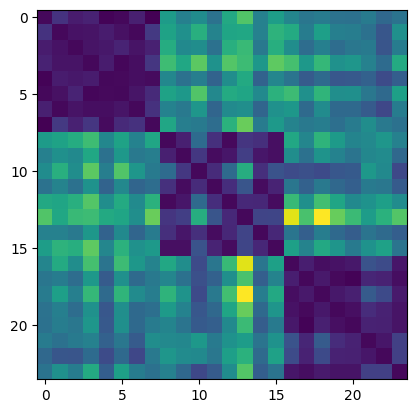

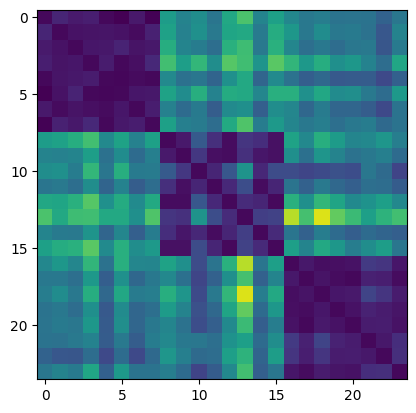

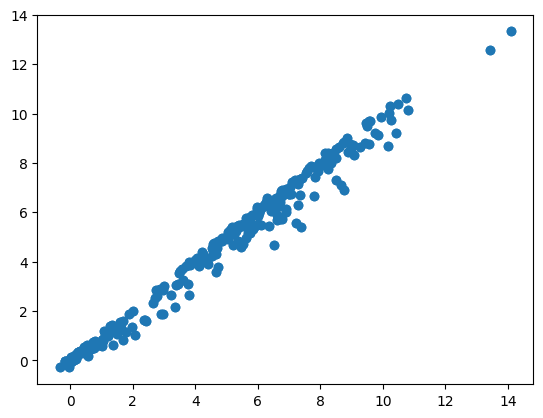

2.372222467587403
3.1110549806540744e-16
-0.7316496972937924


In [8]:
glm_path = os.path.join(gl.baseDir, f'glm1')
cifti_img = 'beta.dscalar.nii'
roi_path = os.path.join(gl.baseDir, gl.roiDir)
pcm_path = os.path.join(gl.baseDir, gl.pcmDir)
days = [3, 9, 23]

cifti_img = nb.load(os.path.join(glm_path, f'subj101', cifti_img))
beta_img = nt.volume_from_cifti(cifti_img, struct_names=['CortexLeft', 'CortexRight'])

mask = nb.load(os.path.join(roi_path, f'subj101', 'ROI.L.PMd.nii'))
coords = nt.get_mask_coords(mask)

chords = get_trained_and_untrained(101)
regressor_mapping = {
    f'{day:02d},{chord}': i
    for i, (day, chord) in enumerate(
        (d, c) for d in days for c in chords
    )
}

betas = nt.sample_image(beta_img, coords[0], coords[1], coords[2], interpolation=0).T
betas = betas[:, np.all(~np.isnan(betas), axis=0)]

reginfo = np.char.split(cifti_img.header.get_axis(0).name, sep='.')
cond_vec = np.array([regressor_mapping[r[0]] for r in reginfo])
part_vec = np.array([int(r[1]) for r in reginfo])

obs_des = {'cond_vec': cond_vec,
                   'part_vec': part_vec}

Y = pcm.dataset.Dataset(betas, obs_descriptors=obs_des)
G1, _ = pcm.est_G_crossval(Y.measurements,
                              Y.obs_descriptors['cond_vec'],
                              Y.obs_descriptors['part_vec'],
                              X=pcm.matrix.indicator(Y.obs_descriptors['part_vec']))
D1 = pcm.G_to_dist(G1)
Y = pcm.dataset.Dataset(betas - betas.mean(axis=1, keepdims=True), obs_descriptors=obs_des)
G2, _ = pcm.est_G_crossval(Y.measurements,
                              Y.obs_descriptors['cond_vec'],
                              Y.obs_descriptors['part_vec'],
                              X=pcm.matrix.indicator(Y.obs_descriptors['part_vec']))
D2 = pcm.G_to_dist(G2)

# plt.imshow(pcm.G_to_dist(G1))
plt.imshow(D1, vmin=D1.min(), vmax=D1.max())
plt.show()
# plt.imshow(pcm.G_to_dist(G2))
plt.imshow(D2, vmin=D1.min(), vmax=D1.max())
plt.show()

plt.scatter(D1, D2)
plt.show()

Y = betas
Yd = betas - betas.mean(axis=1, keepdims=True)
X = pcm.matrix.indicator(obs_des['part_vec'])
Yr = Y.copy()
Yr -= X @ pinv(X) @ Yr

# fig, axs = plt.subplots(1, 2, sharex=True, sharey=True)
# axs[0].plot(Y[0].T)
# axs[0].plot(Yd[0].T)
# axs[1].plot(Yr[0].T)

print(Y[0].mean())
print(Yd[0].mean())
print(Yr[0].mean())

plt.show()